In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random 
from preprocessing_functions import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score

# Import and undersample the dataset

In [2]:
heart_attack_2020 = pd.read_csv(r'C:\Users\Hp\Documents\Machine_learning_projects\heart_attack_predictions\0_datasets\2020\heart_2020_cleaned.csv')
heart_attack_2020 = undersample_data(heart_attack_2020, 'HeartDisease')
print(heart_attack_2020.value_counts('HeartDisease'))
heart_attack_2020.head()

HeartDisease
No     27373
Yes    27373
Name: count, dtype: int64


,HeartDisease,BMI,Smoking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
111390,No,25.02,No,No,No,Female,50-54,White,No,Yes,Good,6.0,Yes,No,Yes
250162,No,23.30,No,No,No,Female,50-54,Black,No,Yes,Good,7.0,No,No,No
230713,No,25.77,Yes,No,No,Male,45-49,White,No,Yes,Very good,4.0,Yes,No,No
153210,No,25.61,Yes,Yes,No,Female,25-29,White,Yes,No,Fair,6.0,No,No,No
149117,No,31.16,Yes,No,Yes,Female,65-69,Black,No,Yes,Fair,7.0,No,No,No


# Model transforming BMI with log_min_max

## Preprocessing

In [3]:
from preprocessing_functions import *

# numerical features
numerical_features = ['BMI','SleepTime']
# categorical features
categorical_features = ['Smoking', 'Stroke', 'DiffWalking', 'Sex','AgeCategory', 'Race', 'Diabetic', 
                        'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']

heart_attack_2020 = heart_attack_2020[numerical_features + categorical_features + ['HeartDisease']]

# Encoding, scaling and train test split
(Train_df_encoded, Train_labels_encoded), (Valid_df_encoded, 
        Valid_labels_encoded), (Test_df_encoded, Test_labels_encoded) = preprocess_features(heart_attack_2020, one_hot_encoding=False,
                categorical_columns=categorical_features, numerical_tranformer = 'log_min_max',
                numerical_columns=numerical_features, target='HeartDisease')

print(f' train dataset length: {len(Train_df_encoded)}')
print(f' validation dataset length: {len(Valid_df_encoded)}')
print(f' test dataset length: {len(Test_df_encoded)}')

# Creating fast processing dataset
Dataset_train, Dataset_valid, Dataset_test = create_fast_preprocessing_odds(Train_df_encoded, Train_labels_encoded,
        Valid_df_encoded, Valid_labels_encoded, Test_df_encoded, Test_labels_encoded)

Dataset_train

 train dataset length: 46839
 validation dataset length: 4074
 test dataset length: 3833


c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 46), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Creating checkpoint callback

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='Dense_model_best.h5',
    save_weights_only=False,  
    monitor='val_accuracy',  
    save_best_only=True, 
    verbose=1  
)

## Creating the model

In [5]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(Train_df_encoded.shape[1],), name = 'input_layer')
x = layers.Dense(96, activation = 'relu')(inputs)
x = layers.Dense(96)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation = 'relu')(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dense(32)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_dense = tf.keras.Model(inputs, outputs)

model_dense.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [6]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

dense_history = model_dense.fit(
                                Dataset_train,
                                epochs=50,
                                validation_data=Dataset_valid,
                                validation_steps=len(Dataset_valid),
                                callbacks=[checkpoint_callback]
                                )

Epoch 1/50


1458/1464 [============================>.] - ETA: 0s - loss: 0.5394 - accuracy: 0.7413
Epoch 1: val_accuracy improved from -inf to 0.76436, saving model to Dense_model_best.h5
1464/1464 [==============================] - 4s 2ms/step - loss: 0.5390 - accuracy: 0.7416 - val_loss: 0.4931 - val_accuracy: 0.7644
Epoch 2/50
1454/1464 [============================>.] - ETA: 0s - loss: 0.5143 - accuracy: 0.7604
Epoch 2: val_accuracy improved from 0.76436 to 0.76559, saving model to Dense_model_best.h5
1464/1464 [==============================] - 3s 2ms/step - loss: 0.5141 - accuracy: 0.7605 - val_loss: 0.4952 - val_accuracy: 0.7656
Epoch 3/50
1448/1464 [============================>.] - ETA: 0s - loss: 0.5099 - accuracy: 0.7637
Epoch 3: val_accuracy did not improve from 0.76559
1464/1464 [==============================] - 2s 2ms/step - loss: 0.5097 - accuracy: 0.7639 - val_loss: 0.5008 - val_accuracy: 0.7639
Epoch 4/50
1430/1464 [============================>.] - ETA: 0s - loss: 0.5085 - accur

### Evaluating the model

0

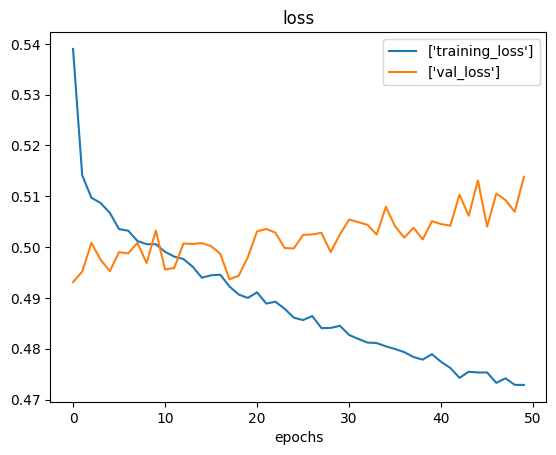

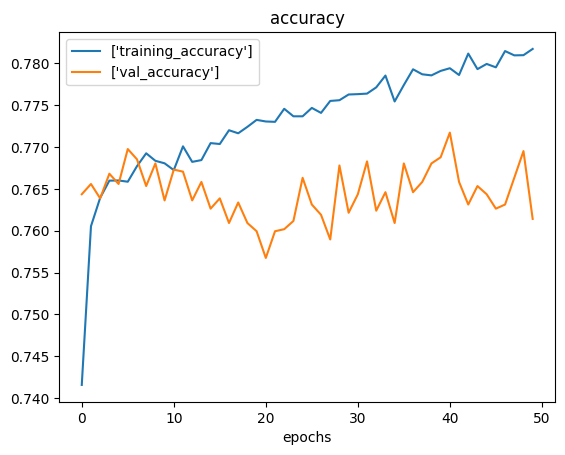

In [8]:
from helper_functions import plot_loss_curve  

plot_loss_curve(dense_history)

In [17]:
test_pred = model_dense.predict(Dataset_test)

print(classification_report(tf.round(test_pred), Test_labels_encoded))

  1/120 [..............................] - ETA: 1s

120/120 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75      1824
         1.0       0.78      0.76      0.77      2009

    accuracy                           0.76      3833
   macro avg       0.76      0.76      0.76      3833
weighted avg       0.76      0.76      0.76      3833



## Finding the ideal learning rate

In [21]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(Train_df_encoded.shape[1],), name = 'input_layer')
x = layers.Dense(96, activation = 'relu')(inputs)
x = layers.Dense(96)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation = 'relu')(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dense(32)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

lr_model_dense = tf.keras.Model(inputs, outputs)

lr_model_dense.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

#creo il learning rate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5*10**(epoch/20))

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

find_lr_history = lr_model_dense.fit(
                                Dataset_train,
                                epochs=50,
                                validation_data=Dataset_valid,
                                validation_steps=len(Dataset_valid),
                                callbacks=[lr_scheduler]
                                )

Epoch 1/50
1464/1464 [==============================] - 4s 2ms/step - loss: 0.6926 - accuracy: 0.5079 - val_loss: 0.6877 - val_accuracy: 0.5741 - lr: 1.0000e-05
Epoch 2/50
1464/1464 [==============================] - 3s 2ms/step - loss: 0.6842 - accuracy: 0.5380 - val_loss: 0.6721 - val_accuracy: 0.6789 - lr: 1.1220e-05
Epoch 3/50
1464/1464 [==============================] - 2s 2ms/step - loss: 0.6653 - accuracy: 0.5876 - val_loss: 0.6370 - val_accuracy: 0.7214 - lr: 1.2589e-05
Epoch 4/50
1464/1464 [==============================] - 2s 2ms/step - loss: 0.6345 - accuracy: 0.6654 - val_loss: 0.5937 - val_accuracy: 0.7275 - lr: 1.4125e-05
Epoch 5/50
1464/1464 [==============================] - 2s 2ms/step - loss: 0.6042 - accuracy: 0.7060 - val_loss: 0.5547 - val_accuracy: 0.7371 - lr: 1.5849e-05
Epoch 6/50
1464/1464 [==============================] - 2s 2ms/step - loss: 0.5839 - accuracy: 0.7221 - val_loss: 0.5335 - val_accuracy: 0.7447 - lr: 1.7783e-05
Epoch 7/50
1464/1464 [============

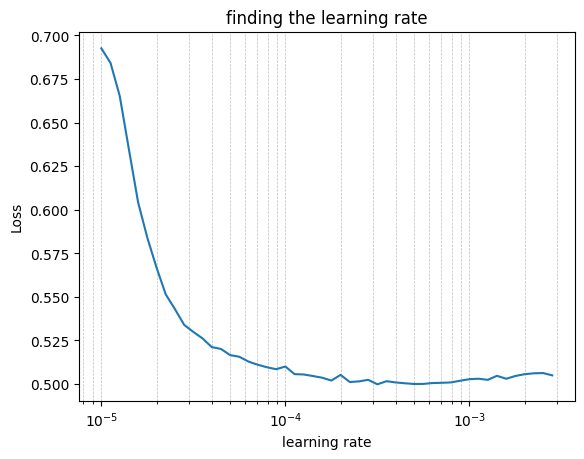

In [22]:
# plotting the loss function in function of the learning rate
lrs = 1e-5 * (10**(tf.range(50)/20))
plt.semilogx(lrs, find_lr_history.history['loss'])
plt.xlabel('learning rate')
plt.ylabel('Loss')
plt.title('finding the learning rate')
plt.grid(which='both', axis='x', linewidth=0.5, linestyle='--', color='gray',
         alpha=0.5, markevery=0.001)


## Model with best lr

In [34]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(Train_df_encoded.shape[1],), name = 'input_layer')
x = layers.Dense(96, activation = 'relu')(inputs)
x = layers.Dense(96)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation = 'relu')(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dense(32)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_dense = tf.keras.Model(inputs, outputs)

model_dense.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    metrics=['accuracy']
)

In [35]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

dense_history = model_dense.fit(
                                Dataset_train,
                                epochs=60,
                                validation_data=Dataset_valid,
                                validation_steps=len(Dataset_valid),
                                callbacks=[checkpoint_callback]
                                )

Epoch 1/60


1452/1464 [============================>.] - ETA: 0s - loss: 0.5483 - accuracy: 0.7338
Epoch 1: val_accuracy did not improve from 0.77540
1464/1464 [==============================] - 4s 2ms/step - loss: 0.5479 - accuracy: 0.7342 - val_loss: 0.4929 - val_accuracy: 0.7617
Epoch 2/60
1451/1464 [============================>.] - ETA: 0s - loss: 0.5158 - accuracy: 0.7627
Epoch 2: val_accuracy did not improve from 0.77540
1464/1464 [==============================] - 2s 2ms/step - loss: 0.5156 - accuracy: 0.7630 - val_loss: 0.4960 - val_accuracy: 0.7661
Epoch 3/60
1447/1464 [============================>.] - ETA: 0s - loss: 0.5093 - accuracy: 0.7644
Epoch 3: val_accuracy did not improve from 0.77540
1464/1464 [==============================] - 2s 2ms/step - loss: 0.5090 - accuracy: 0.7647 - val_loss: 0.4922 - val_accuracy: 0.7685
Epoch 4/60
1441/1464 [============================>.] - ETA: 0s - loss: 0.5056 - accuracy: 0.7654
Epoch 4: val_accuracy did not improve from 0.77540
1464/1464 [=====

Th best learning rate doesn't have the best val_accuracy performances.